
# Set up GPU

In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="1,0" # disables GPU to run on CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
config = tf.ConfigProto()
#config = tf.ConfigProto(device_count = {'GPU': 1})
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import EELScodes
import dm4reader
import dm4test.test_dm4
import types
import sklearn.model_selection 
import moviepy.video.io.ImageSequenceClip
import copy
import io
import base64
import IPython.display

Using TensorFlow backend.


# Neural net settings

In [27]:
layer_type='lstm'
size=64
encode_layers=4
decode_layers=4
embedding=16
lr=3e-5
dropout=0.2
l1_norm=1e-4
batch_norm=[True, True]
batch_size=11000
epochs=1000

xlimits=[70,140]
maxeV=750
maxeV=(maxeV-300)*2

backgroundregion=np.arange(80,180,1)
activeregion=np.arange(191,205,1)

postfix='_lesscut_sg_2dSG_edit'

# Load data

In [4]:
eelsdata='EELS Spectrum Image.dm4'
data=types.SimpleNamespace()

dm4data = dm4reader.DM4File.open(eelsdata)

tags = dm4data.read_directory()
image_data_tag = tags.named_subdirs['ImageList'].unnamed_subdirs[1].named_subdirs['ImageData']
image_tag = image_data_tag.named_tags['Data']
#print(tags)

XDim = dm4data.read_tag_data(image_data_tag.named_subdirs['Dimensions'].unnamed_tags[0])
YDim = dm4data.read_tag_data(image_data_tag.named_subdirs['Dimensions'].unnamed_tags[1])
#print(XDim)
data.I = np.array(dm4data.read_tag_data(image_tag), dtype=np.uint16)
data.I = np.reshape(data.I, (-1,YDim, XDim))
data.I = np.swapaxes(data.I,0,2)
data.I = np.swapaxes(data.I,0,1)
#output_fullpath = "sample.tif"
#image = PIL.Image.fromarray(np_array, 'I;16')
#image.save(output_fullpath)
#dm4test.test_dm4.print_tag_directory_tree(dm4data,tags)
data.I=data.I[:,:,:maxeV]
shape=data.I.shape
#print(data.I.shape)
data.E=np.arange(data.I.shape[2])*0.5+300
print(data.I.shape)

(146, 228, 900)


# SG-filtering

In [5]:
#1d spectral filter
data.I=EELScodes.savgol(np.float64(np.copy(data.I)), num_to_remove=3, window_length=5, polyorder=3,fit_type='linear')
data.I=data.I.reshape(shape)
#2d filter for each image
tempdata=[]
for i in range(data.I.shape[2]):
    tempdata.append(EELScodes.sgolay2d(data.I[:,:,i],window_length=5, polyorder=3))
data.I=np.array(tempdata)
data.I = np.swapaxes(data.I,0,2)
data.I = np.swapaxes(data.I,0,1)
print(data.I.shape)

(146, 228, 900)


# Plot image and cut to area of interest

Text(0.5, 1.0, 'Area of interest')

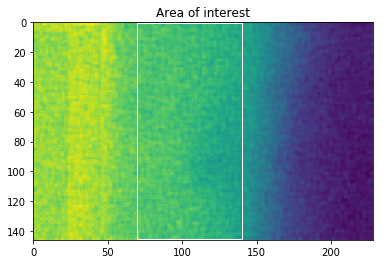

In [6]:
fig= plt.figure(figsize=(12,4))
ax=fig.subplots(1,1)
ax.pcolor(data.I[:,:,0])
ax.axis('scaled')
ax.invert_yaxis()
ax.plot(xlimits,[0.5,0.5],color=[1,1,1,1],lw=1)
ax.plot([xlimits[0],xlimits[0]],[0.5,data.I.shape[0]-0.5],color=[1,1,1,1],lw=1)
ax.plot([xlimits[1],xlimits[1]],[0.5,data.I.shape[0]-0.5],color=[1,1,1,1],lw=1)
ax.plot(xlimits,[data.I.shape[0]-0.5,data.I.shape[0]-0.5],color=[1,1,1,1],lw=1)
ax.set_title('Area of interest')

In [7]:
data.I=data.I[:,xlimits[0]:xlimits[1],:]

# Backround subtraction based on power law fit of selected region

Text(300, 10000, 'Background subtration based on \nfit to colored region of spectra')

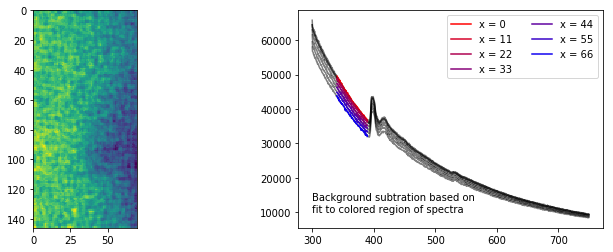

In [8]:
fig= plt.figure(figsize=(12,4))
ax=fig.subplots(1,2)
ax[0].pcolor(data.I[:,:,0])
ax[0].axis('scaled')
ax[0].invert_yaxis()
xlen=data.I.shape[1]
for i in np.arange(0,xlen,xlen//6):
    color=[1*(xlen-i)/xlen,0,1*i/xlen,1]
    DataLineSum=np.sum(data.I[:,i,:], axis=0)
    ax[1].plot(data.E,DataLineSum,color=[0,0,0,0.5])
    DataLineSum=np.sum(data.I[:,i,backgroundregion], axis=0)
    ax[1].plot(data.E[backgroundregion],DataLineSum,color=color,label='x = '+str(i))
ax[1].legend(fontsize=10,ncol=2)
ax[1].text(300,10000,'Background subtration based on \nfit to colored region of spectra')

In [9]:
data.subbed=EELScodes.subtractExpBackground(data.I[:,:,:],backgroundregion)

# Cut data to region of interest

In [10]:
data.subbedCut=data.subbed[:,:,activeregion]
data.ECut=data.E[activeregion]

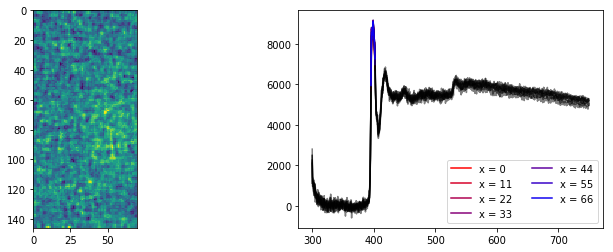

In [11]:
fig= plt.figure(figsize=(12,4))
ax=fig.subplots(1,2)
ax[0].pcolor(data.subbedCut[:,:,0])
ax[0].axis('scaled')
ax[0].invert_yaxis()
xlen=data.I.shape[1]
for i in np.arange(0,xlen,xlen//6):
    color=[1*(xlen-i)/xlen,0,1*i/xlen,1]
    DataLineSum=np.sum(data.subbed[:,i,:], axis=0)
    ax[1].plot(data.E,DataLineSum,color=[0,0,0,0.5])
    DataLineSum=np.sum(data.subbedCut[:,i,:], axis=0)
    ax[1].plot(data.ECut,DataLineSum,color=color,label='x = '+str(i))
ax[0].plot(xlimits,[100,100])
ax[1].legend(fontsize=10,ncol=2)

# Normalize data

In [12]:
data.subbedCutNorm, data.std, data.mean=EELScodes.normalize(data.subbedCut,extra_output=True)

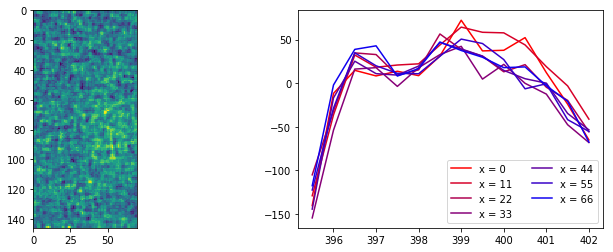

In [13]:
fig= plt.figure(figsize=(12,4))
ax=fig.subplots(1,2)
ax[0].pcolor(data.subbedCutNorm[:,:,0])
ax[0].axis('scaled')
ax[0].invert_yaxis()
xlen=data.I.shape[1]
for i in np.arange(0,xlen,xlen//6):
    color=[1*(xlen-i)/xlen,0,1*i/xlen,1]
    DataLineSum=np.sum(data.subbedCutNorm[i,:,:], axis=0)
    ax[1].plot(data.ECut,DataLineSum,color=color,label='x = '+str(i))
ax[0].plot(xlimits,[100,100])
ax[1].legend(fontsize=10,ncol=2)

# Set up NN

In [14]:
trainingforML,validationforML=sklearn.model_selection.train_test_split(data.subbedCutNorm, random_state=42)
trainingforML=data.subbedCutNorm

In [28]:

#layer_type='lstm'
#size=64
#encode_layers=4
#decode_layers=4
#embedding=16
#lr=3e-5
#dropout=0.2
#l1_norm=1e-4
#batch_norm=[True, True]
#batch_size=900
#epochs=500
steps=trainingforML.shape[-1]
'''rnn(layer_type, size, encode_layers,
        decode_layers, embedding,
        steps, lr=3e-5, drop_frac=0.,
        bidirectional=True, l1_norm=1e-4,
        batch_norm=[False, False], **kwargs):'''
labelstring='_'.join([layer_type,str(size),str(encode_layers),str(decode_layers)
         ,str(embedding),str(lr),str(dropout)
         ,str(l1_norm),str(batch_norm),str(batch_size)
         ,str(epochs),str(steps)])
labelstring=labelstring.replace(', ','').replace('[','').replace(']','').replace('.','p')+postfix
print(labelstring)


lstm_64_4_4_16_3e-05_0p2_0p0001_TrueTrue_11000_1000_14_lesscut_sg_2dSG_edit


# Set up training and validation sets
Use all data for training, random sample of rows for validation (to track progress)

Text(0.5, 1.0, 'Validation data')

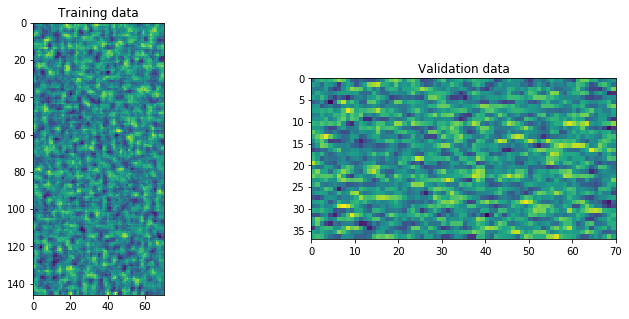

In [16]:
fig= plt.figure(figsize=(12,5))
ax=fig.subplots(1,2)
ax[0].pcolor(trainingforML[:,:,10])
ax[0].axis('scaled')
ax[0].invert_yaxis()
ax[0].set_title('Training data')
ax[1].pcolor(validationforML[:,:,10])
ax[1].axis('scaled')
ax[1].invert_yaxis()
ax[1].set_title('Validation data')

In [17]:
CAFM_model, run_id = EELScodes.rnn(layer_type, size, encode_layers,
                              decode_layers, embedding, steps,
                              lr=lr, drop_frac=dropout, l1_norm=l1_norm,
                              batch_norm=batch_norm)

# Train Model

In [ ]:
if not os.path.exists('./EELSmodels/'):
    os.mkdir('./EELSmodels/')
model_folder = './EELSmodels/'+labelstring
if not os.path.exists(model_folder):
    os.mkdir(model_folder)

# trains the model saving results as checkpoints
EELScodes.train_model(run_id, CAFM_model,
                    trainingforML.reshape((-1,steps)),
                    validationforML.reshape((-1,steps)),
                    model_folder,
                    batch_size=batch_size,
                    epochs=epochs)

Train on 10220 samples, validate on 2590 samples
Epoch 1/1000
10220/10220 [==============================] - 1s 105us/step - loss: 1.3989 - val_loss: 0.9954
Epoch 2/1000
10220/10220 [==============================] - 1s 106us/step - loss: 1.3935 - val_loss: 0.9948
Epoch 3/1000
10220/10220 [==============================] - 1s 104us/step - loss: 1.3903 - val_loss: 0.9943
Epoch 4/1000
10220/10220 [==============================] - 1s 106us/step - loss: 1.3867 - val_loss: 0.9937
Epoch 5/1000
10220/10220 [==============================] - 1s 105us/step - loss: 1.3829 - val_loss: 0.9931
Epoch 6/1000
10220/10220 [==============================] - 1s 102us/step - loss: 1.3823 - val_loss: 0.9926
Epoch 7/1000
10220/10220 [==============================] - 1s 106us/step - loss: 1.3783 - val_loss: 0.9920
Epoch 8/1000
10220/10220 [==============================] - 1s 104us/step - loss: 1.3748 - val_loss: 0.9915
Epoch 9/1000
10220/10220 [==============================] - 1s 103us/step - loss: 1.372

Epoch 76/1000
10220/10220 [==============================] - 1s 107us/step - loss: 1.2233 - val_loss: 0.9548
Epoch 77/1000
10220/10220 [==============================] - 1s 101us/step - loss: 1.2193 - val_loss: 0.9539
Epoch 78/1000
10220/10220 [==============================] - 1s 102us/step - loss: 1.2182 - val_loss: 0.9530
Epoch 79/1000
10220/10220 [==============================] - 1s 102us/step - loss: 1.2164 - val_loss: 0.9521
Epoch 80/1000
10220/10220 [==============================] - 1s 103us/step - loss: 1.2137 - val_loss: 0.9512
Epoch 81/1000
10220/10220 [==============================] - 1s 103us/step - loss: 1.2134 - val_loss: 0.9503
Epoch 82/1000
10220/10220 [==============================] - 1s 103us/step - loss: 1.2096 - val_loss: 0.9494
Epoch 83/1000
10220/10220 [==============================] - 1s 103us/step - loss: 1.2084 - val_loss: 0.9486
Epoch 84/1000
10220/10220 [==============================] - 1s 105us/step - loss: 1.2092 - val_loss: 0.9477
Epoch 85/1000
10220

Epoch 151/1000
10220/10220 [==============================] - 1s 102us/step - loss: 1.0740 - val_loss: 0.8487
Epoch 152/1000
10220/10220 [==============================] - 1s 105us/step - loss: 1.0715 - val_loss: 0.8463
Epoch 153/1000
10220/10220 [==============================] - 1s 102us/step - loss: 1.0696 - val_loss: 0.8438
Epoch 154/1000
10220/10220 [==============================] - 1s 104us/step - loss: 1.0666 - val_loss: 0.8411
Epoch 155/1000
10220/10220 [==============================] - 1s 106us/step - loss: 1.0630 - val_loss: 0.8385
Epoch 156/1000
10220/10220 [==============================] - 1s 105us/step - loss: 1.0633 - val_loss: 0.8358
Epoch 157/1000
10220/10220 [==============================] - 1s 103us/step - loss: 1.0597 - val_loss: 0.8331
Epoch 158/1000
10220/10220 [==============================] - 1s 103us/step - loss: 1.0563 - val_loss: 0.8302
Epoch 159/1000
10220/10220 [==============================] - 1s 103us/step - loss: 1.0561 - val_loss: 0.8271
Epoch 160/

Epoch 226/1000
10220/10220 [==============================] - 1s 102us/step - loss: 0.8471 - val_loss: 0.6360
Epoch 227/1000
10220/10220 [==============================] - 1s 104us/step - loss: 0.8443 - val_loss: 0.6361
Epoch 228/1000
10220/10220 [==============================] - 1s 105us/step - loss: 0.8416 - val_loss: 0.6364
Epoch 229/1000
10220/10220 [==============================] - 1s 106us/step - loss: 0.8392 - val_loss: 0.6367
Epoch 230/1000
10220/10220 [==============================] - 1s 108us/step - loss: 0.8378 - val_loss: 0.6373
Epoch 231/1000
10220/10220 [==============================] - 1s 109us/step - loss: 0.8339 - val_loss: 0.6380
Epoch 232/1000
10220/10220 [==============================] - 1s 110us/step - loss: 0.8330 - val_loss: 0.6389
Epoch 233/1000
10220/10220 [==============================] - 1s 110us/step - loss: 0.8279 - val_loss: 0.6399
Epoch 234/1000
10220/10220 [==============================] - 1s 111us/step - loss: 0.8275 - val_loss: 0.6409
Epoch 235/

Epoch 301/1000
10220/10220 [==============================] - 1s 111us/step - loss: 0.7206 - val_loss: 0.6601
Epoch 302/1000
10220/10220 [==============================] - 1s 111us/step - loss: 0.7209 - val_loss: 0.6601
Epoch 303/1000
10220/10220 [==============================] - 1s 111us/step - loss: 0.7174 - val_loss: 0.6603
Epoch 304/1000
10220/10220 [==============================] - 1s 113us/step - loss: 0.7176 - val_loss: 0.6603
Epoch 305/1000
10220/10220 [==============================] - 1s 112us/step - loss: 0.7182 - val_loss: 0.6601
Epoch 306/1000
10220/10220 [==============================] - 1s 113us/step - loss: 0.7156 - val_loss: 0.6598
Epoch 307/1000
10220/10220 [==============================] - 1s 111us/step - loss: 0.7150 - val_loss: 0.6595
Epoch 308/1000
10220/10220 [==============================] - 1s 111us/step - loss: 0.7126 - val_loss: 0.6592
Epoch 309/1000
10220/10220 [==============================] - 1s 111us/step - loss: 0.7123 - val_loss: 0.6592
Epoch 310/

Epoch 376/1000
10220/10220 [==============================] - 1s 112us/step - loss: 0.6753 - val_loss: 0.6389
Epoch 377/1000
10220/10220 [==============================] - 1s 111us/step - loss: 0.6761 - val_loss: 0.6383
Epoch 378/1000
10220/10220 [==============================] - 1s 111us/step - loss: 0.6757 - val_loss: 0.6375
Epoch 379/1000
10220/10220 [==============================] - 1s 110us/step - loss: 0.6745 - val_loss: 0.6367
Epoch 380/1000
10220/10220 [==============================] - 1s 112us/step - loss: 0.6745 - val_loss: 0.6359
Epoch 381/1000
10220/10220 [==============================] - 1s 109us/step - loss: 0.6745 - val_loss: 0.6350
Epoch 382/1000
10220/10220 [==============================] - 1s 106us/step - loss: 0.6733 - val_loss: 0.6342
Epoch 383/1000
10220/10220 [==============================] - 1s 104us/step - loss: 0.6742 - val_loss: 0.6334
Epoch 384/1000
10220/10220 [==============================] - 1s 105us/step - loss: 0.6721 - val_loss: 0.6327
Epoch 385/

Epoch 451/1000
10220/10220 [==============================] - 1s 103us/step - loss: 0.6509 - val_loss: 0.6153
Epoch 452/1000
10220/10220 [==============================] - 1s 103us/step - loss: 0.6526 - val_loss: 0.6153
Epoch 453/1000
10220/10220 [==============================] - 1s 106us/step - loss: 0.6525 - val_loss: 0.6152
Epoch 454/1000
10220/10220 [==============================] - 1s 109us/step - loss: 0.6505 - val_loss: 0.6151
Epoch 455/1000
10220/10220 [==============================] - 1s 105us/step - loss: 0.6511 - val_loss: 0.6149
Epoch 456/1000
10220/10220 [==============================] - 1s 105us/step - loss: 0.6500 - val_loss: 0.6147
Epoch 457/1000
10220/10220 [==============================] - 1s 106us/step - loss: 0.6490 - val_loss: 0.6144
Epoch 458/1000
10220/10220 [==============================] - 1s 106us/step - loss: 0.6493 - val_loss: 0.6140
Epoch 459/1000
10220/10220 [==============================] - 1s 104us/step - loss: 0.6507 - val_loss: 0.6136
Epoch 460/

Epoch 526/1000
10220/10220 [==============================] - 1s 111us/step - loss: 0.6344 - val_loss: 0.5985
Epoch 527/1000
10220/10220 [==============================] - 1s 112us/step - loss: 0.6342 - val_loss: 0.5980
Epoch 528/1000
10220/10220 [==============================] - 1s 108us/step - loss: 0.6345 - val_loss: 0.5974
Epoch 529/1000
10220/10220 [==============================] - 1s 108us/step - loss: 0.6336 - val_loss: 0.5968
Epoch 530/1000
10220/10220 [==============================] - 1s 104us/step - loss: 0.6337 - val_loss: 0.5964
Epoch 531/1000
10220/10220 [==============================] - 1s 103us/step - loss: 0.6347 - val_loss: 0.5959
Epoch 532/1000
10220/10220 [==============================] - 1s 104us/step - loss: 0.6334 - val_loss: 0.5955
Epoch 533/1000
10220/10220 [==============================] - 1s 105us/step - loss: 0.6341 - val_loss: 0.5949
Epoch 534/1000
10220/10220 [==============================] - 1s 104us/step - loss: 0.6329 - val_loss: 0.5943
Epoch 535/

Epoch 601/1000
10220/10220 [==============================] - 1s 104us/step - loss: 0.6211 - val_loss: 0.5802
Epoch 602/1000
10220/10220 [==============================] - 1s 106us/step - loss: 0.6222 - val_loss: 0.5801
Epoch 603/1000
10220/10220 [==============================] - 1s 103us/step - loss: 0.6216 - val_loss: 0.5801
Epoch 604/1000
10220/10220 [==============================] - 1s 105us/step - loss: 0.6216 - val_loss: 0.5801
Epoch 605/1000
10220/10220 [==============================] - 1s 105us/step - loss: 0.6211 - val_loss: 0.5798
Epoch 606/1000
10220/10220 [==============================] - 1s 106us/step - loss: 0.6207 - val_loss: 0.5796
Epoch 607/1000
10220/10220 [==============================] - 1s 104us/step - loss: 0.6203 - val_loss: 0.5792
Epoch 608/1000
10220/10220 [==============================] - 1s 102us/step - loss: 0.6198 - val_loss: 0.5789
Epoch 609/1000
10220/10220 [==============================] - 1s 104us/step - loss: 0.6191 - val_loss: 0.5789
Epoch 610/

Epoch 676/1000
10220/10220 [==============================] - 1s 105us/step - loss: 0.6100 - val_loss: 0.5633
Epoch 677/1000
10220/10220 [==============================] - 1s 105us/step - loss: 0.6094 - val_loss: 0.5632
Epoch 678/1000
10220/10220 [==============================] - 1s 106us/step - loss: 0.6102 - val_loss: 0.5632
Epoch 679/1000
10220/10220 [==============================] - 1s 106us/step - loss: 0.6107 - val_loss: 0.5633
Epoch 680/1000
10220/10220 [==============================] - 1s 107us/step - loss: 0.6102 - val_loss: 0.5635
Epoch 681/1000
10220/10220 [==============================] - 1s 107us/step - loss: 0.6095 - val_loss: 0.5638
Epoch 682/1000
10220/10220 [==============================] - 1s 109us/step - loss: 0.6095 - val_loss: 0.5640
Epoch 683/1000
10220/10220 [==============================] - 1s 111us/step - loss: 0.6089 - val_loss: 0.5642
Epoch 684/1000
10220/10220 [==============================] - 1s 113us/step - loss: 0.6092 - val_loss: 0.5645
Epoch 685/

Epoch 751/1000
10220/10220 [==============================] - 1s 112us/step - loss: 0.5998 - val_loss: 0.5505
Epoch 752/1000
10220/10220 [==============================] - 1s 110us/step - loss: 0.5992 - val_loss: 0.5507
Epoch 753/1000
10220/10220 [==============================] - 1s 111us/step - loss: 0.5997 - val_loss: 0.5509
Epoch 754/1000
10220/10220 [==============================] - 1s 110us/step - loss: 0.5996 - val_loss: 0.5509
Epoch 755/1000
10220/10220 [==============================] - 1s 110us/step - loss: 0.5984 - val_loss: 0.5508
Epoch 756/1000
10220/10220 [==============================] - 1s 111us/step - loss: 0.6000 - val_loss: 0.5507
Epoch 757/1000
10220/10220 [==============================] - 1s 112us/step - loss: 0.5989 - val_loss: 0.5508
Epoch 758/1000
10220/10220 [==============================] - 1s 111us/step - loss: 0.5984 - val_loss: 0.5509
Epoch 759/1000
10220/10220 [==============================] - 1s 112us/step - loss: 0.5986 - val_loss: 0.5510
Epoch 760/

Epoch 826/1000
10220/10220 [==============================] - 1s 111us/step - loss: 0.5911 - val_loss: 0.5419
Epoch 827/1000
10220/10220 [==============================] - 1s 111us/step - loss: 0.5899 - val_loss: 0.5414
Epoch 828/1000
10220/10220 [==============================] - 1s 107us/step - loss: 0.5898 - val_loss: 0.5409
Epoch 829/1000
10220/10220 [==============================] - 1s 106us/step - loss: 0.5892 - val_loss: 0.5404
Epoch 830/1000
10220/10220 [==============================] - 1s 107us/step - loss: 0.5894 - val_loss: 0.5399
Epoch 831/1000
10220/10220 [==============================] - 1s 105us/step - loss: 0.5908 - val_loss: 0.5394
Epoch 832/1000
10220/10220 [==============================] - 1s 105us/step - loss: 0.5897 - val_loss: 0.5391
Epoch 833/1000
10220/10220 [==============================] - 1s 105us/step - loss: 0.5891 - val_loss: 0.5387
Epoch 834/1000
10220/10220 [==============================] - 1s 105us/step - loss: 0.5884 - val_loss: 0.5383
Epoch 835/

Epoch 901/1000
10220/10220 [==============================] - 1s 106us/step - loss: 0.5817 - val_loss: 0.5244
Epoch 902/1000
10220/10220 [==============================] - 1s 106us/step - loss: 0.5825 - val_loss: 0.5243
Epoch 903/1000
10220/10220 [==============================] - 1s 106us/step - loss: 0.5814 - val_loss: 0.5241
Epoch 904/1000
10220/10220 [==============================] - 1s 102us/step - loss: 0.5821 - val_loss: 0.5240
Epoch 905/1000
10220/10220 [==============================] - 1s 104us/step - loss: 0.5812 - val_loss: 0.5237
Epoch 906/1000
10220/10220 [==============================] - 1s 104us/step - loss: 0.5811 - val_loss: 0.5235
Epoch 907/1000
10220/10220 [==============================] - 1s 104us/step - loss: 0.5800 - val_loss: 0.5233
Epoch 908/1000
10220/10220 [==============================] - 1s 102us/step - loss: 0.5805 - val_loss: 0.5232
Epoch 909/1000
10220/10220 [==============================] - 1s 103us/step - loss: 0.5805 - val_loss: 0.5229
Epoch 910/

# Plot maps of embeddings

In [19]:
embeddings = EELScodes.get_activations(CAFM_model,
                                 trainingforML.reshape((-1,steps)),
                                 9)
embeddings=embeddings.reshape((trainingforML.shape[0],trainingforML.shape[1],-1))

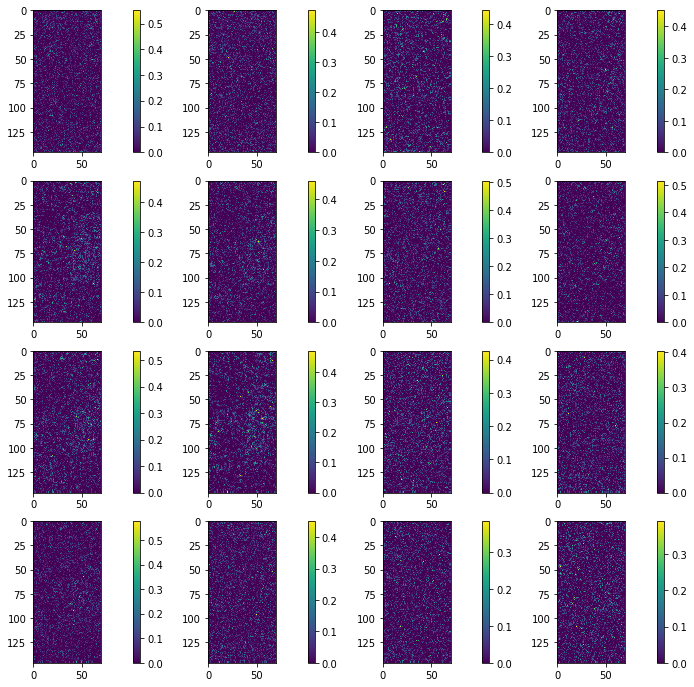

In [20]:
fig= plt.figure(figsize=(12,12))
ax=[]
for i in range(16):
    if np.max(embeddings[:,:,i])>10**-6:
        ax.append(fig.add_subplot(4,4,len(ax)+1))
        pcolor=ax[-1].pcolor(embeddings[:,:,i])
        #pcolor.set_clim(0, 0.001)
        ax[-1].invert_yaxis()
        fig.colorbar(pcolor,ax=ax[-1])
        ax[-1].axis('scaled')
        
fig.savefig(model_folder.strip('/')+'.png')

# Use decoder to look at low level embeddings

In [21]:
decoder=EELScodes.rnn_decoder(CAFM_model,decoder_start=10)

In [22]:
movie_folder = model_folder+'/movie'
if not os.path.exists(movie_folder):
    os.mkdir(movie_folder)


[MoviePy] >>>> Building video ./EELSmodels/lstm_64_4_4_16_3e-05_0p2_0p0001_TrueTrue_11000_100_14_lesscut_sg_2dSG_edit/movie/allmovie.mp4
[MoviePy] Writing video ./EELSmodels/lstm_64_4_4_16_3e-05_0p2_0p0001_TrueTrue_11000_100_14_lesscut_sg_2dSG_edit/movie/allmovie.mp4


 95%|█████████▌| 20/21 [00:00<00:00, 48.84it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./EELSmodels/lstm_64_4_4_16_3e-05_0p2_0p0001_TrueTrue_11000_100_14_lesscut_sg_2dSG_edit/movie/allmovie.mp4 



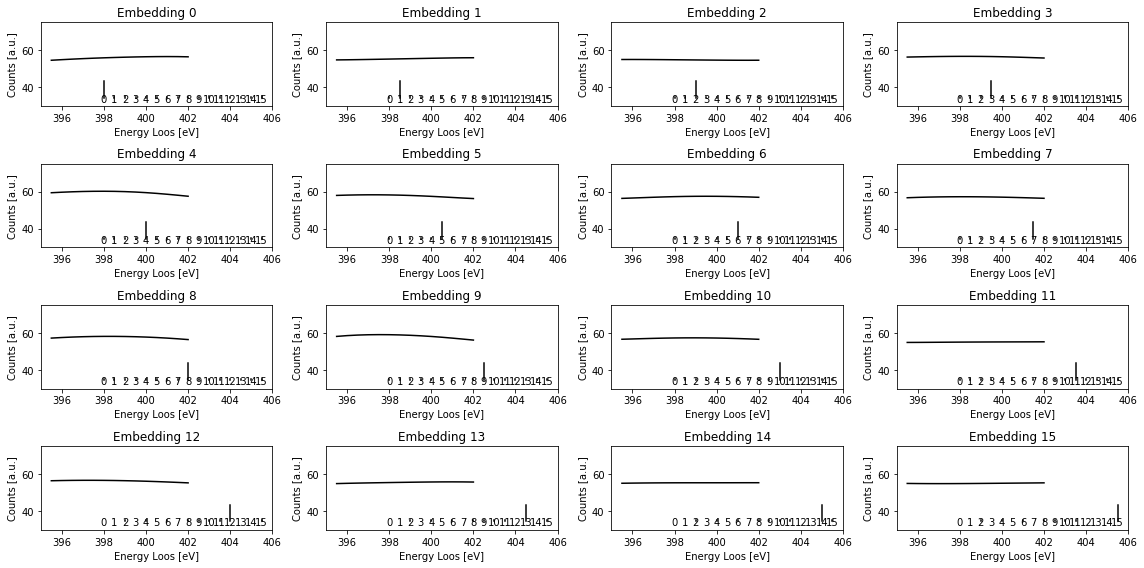

In [23]:
avgembeddings=np.average(embeddings,axis=(0,1))
numframes=10
comps=[]
for comp in range(embedding):
    if np.max(embeddings[:,:,comp])>10**-6:
        comps.append(comp)
rows=(len(comp)+3)//4
fig= plt.figure(figsize=(16,4*rows))
ax=[]
compsteps=[]
avgAmp=[]
i=1
ylim=[30,75]
for i,comp in enumerate(comps):
    comps.append(comp)
    compsteps.append(np.max(embeddings[:,:,comp])/(numframes-1))
    avgAmp.append(avgembeddings[comp]/np.max(embeddings[:,:,comp]))
    ax.append(fig.add_subplot(rows,4,i))
    i+=1
for frame in range(numframes):
    for i,comp in enumerate(comps):
        ax[i].cla()
        curembeddings=copy.deepcopy(avgembeddings)
        curembeddings[comp]=compsteps[i]*frame
        reconstructed = decoder.predict(np.array([curembeddings]))*data.std+data.mean
        ax[i].plot(data.ECut,reconstructed[0],color=[0,0,0,1])
        ax[i].set_ylim(ylim)
        ax[i].set_ylabel('Counts [a.u.]')
        ax[i].set_xlabel('Energy Loos [eV]')    
        ax[i].set_title('Embedding '+str(comp))
        for j,comp2 in enumerate(comps):
            if i==j:
                ax[i].plot([398+i/2,398+i/2],[ylim[0]+(ylim[1]-ylim[0])*0.1,ylim[0]+(ylim[1]-ylim[0])*(0.1+0.2*frame/(numframes-1))],color=[0,0,0,1])
            else:
                ax[i].plot([398+j/2,398+j/2],[ylim[0]+(ylim[1]-ylim[0])*0.1,ylim[0]+(ylim[1]-ylim[0])*(0.1+0.2*avgAmp[j])],color=[0,0,0,1])
            ax[i].text(398+j/2,ylim[0]+(ylim[1]-ylim[0])*0.05,str(comp2),ha='center')
    fig.tight_layout()
    fig.savefig(movie_folder+'/'+str(frame)+'.png')
            
fps=30
comp_folder = movie_folder+'/'+str(comp)
listOfPngFiles=[movie_folder+'/'+str(frame)+'.png' for frame in range(numframes)]
listOfPngFiles=listOfPngFiles+listOfPngFiles[::-1]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(listOfPngFiles, fps=fps)
clip.write_videofile(movie_folder + '/'+'all'+'movie.mp4', fps=fps)


In [24]:
movie=movie_folder + '/allmovie.mp4'
video = io.open(movie, 'r+b').read()
encoded = base64.b64encode(video)
IPython.display.HTML(data='''<video alt="test" controls loop>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

# Difference between embedding 2 and 7

[0.02704176 0.02669761 0.02875167 0.0249256  0.02886619 0.02492939
 0.0289441  0.02350414 0.03285392 0.02918327 0.02824315 0.02421203
 0.02699264 0.02569854 0.02131337 0.02569147]
[MoviePy] >>>> Building video ./EELSmodels/lstm_64_4_4_16_3e-05_0p2_0p0001_TrueTrue_11000_100_14_lesscut_sg_2dSG_edit/movie/2-7movie.mp4
[MoviePy] Writing video ./EELSmodels/lstm_64_4_4_16_3e-05_0p2_0p0001_TrueTrue_11000_100_14_lesscut_sg_2dSG_edit/movie/2-7movie.mp4


100%|██████████| 200/200 [00:00<00:00, 362.41it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./EELSmodels/lstm_64_4_4_16_3e-05_0p2_0p0001_TrueTrue_11000_100_14_lesscut_sg_2dSG_edit/movie/2-7movie.mp4 



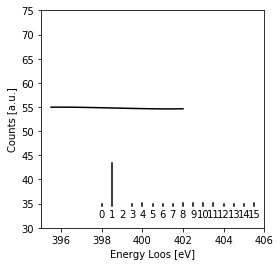

In [25]:
avgembeddings=np.average(embeddings,axis=(0,1))
print(avgembeddings)

numframes=100
fig= plt.figure(figsize=(4,4))
ax=fig.add_subplot(1,1,1)
comp_folder = movie_folder+'/'+'2-7'
if not os.path.exists(comp_folder):
    os.mkdir(comp_folder)
compstep2=np.max(embeddings[:,:,2])/(numframes-1)
compstep7=np.max(embeddings[:,:,7])/(numframes-1)
for frame in range(numframes):
    ax.cla()
    curembeddings=avgembeddings
    curembeddings[2]=compstep2*frame
    curembeddings[7]=compstep7*(numframes-frame-1)
    reconstructed = decoder.predict(np.array([curembeddings]))*data.std+data.mean
    ax.plot(data.ECut,reconstructed[0],color=[0,0,0,1])
    ax.set_ylim([30,75])
    ax.set_ylabel('Counts [a.u.]')
    ax.set_xlabel('Energy Loos [eV]')
    for j,comp2 in enumerate(comps):
        if j==1:
            ax.plot([398+j/2,398+j/2],[ylim[0]+(ylim[1]-ylim[0])*0.1,ylim[0]+(ylim[1]-ylim[0])*(0.1+0.2*frame/(numframes-1))],color=[0,0,0,1])
        elif j==2:
            ax.plot([398+j/2,398+j/2],[ylim[0]+(ylim[1]-ylim[0])*0.1,ylim[0]+(ylim[1]-ylim[0])*(0.1+0.2*(numframes-1-frame)/(numframes-1))],color=[0,0,0,1])
        else:
            ax.plot([398+j/2,398+j/2],[ylim[0]+(ylim[1]-ylim[0])*0.1,ylim[0]+(ylim[1]-ylim[0])*(0.1+0.2*avgAmp[j])],color=[0,0,0,1])
        ax.text(398+j/2,ylim[0]+(ylim[1]-ylim[0])*0.05,str(comp2),ha='center')
    fig.savefig(comp_folder+'/'+str(frame)+'.png')
    
fps=30
#comp_folder = movie_folder+'/'+str(comp)
listOfPngFiles=[comp_folder+'/'+str(frame)+'.png' for frame in range(numframes)]
listOfPngFiles=listOfPngFiles+listOfPngFiles[::-1]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(listOfPngFiles, fps=fps)
clip.write_videofile(movie_folder + '/2-7movie.mp4', fps=fps)

    

In [26]:
movie=movie_folder + '/2-7movie.mp4'
video = io.open(movie, 'r+b').read()
encoded = base64.b64encode(video)
IPython.display.HTML(data='''<video alt="test" controls loop>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))